## Setup inicial

In [ ]:
%pip install fsspec
%pip install keras
%pip install tensorflow
%pip install networkx
%pip install --upgrade typing-extensions
# %pip install pmdarima

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.11.2
    Not uninstalling pygments at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-024ffbf4-e67e-4063-a720-5ad4c438354f
    Can't uninstall 'Pygments'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-024ffbf4-e67e-4063-a720-5ad4c438354f
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-pac

In [ ]:
# General data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox


# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import col, date_format, from_utc_timestamp, to_date


# import pmdarima as pm



# Neural Net modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping

from pyspark.ml.feature import OneHotEncoder

from scipy.stats import chi2_contingency


from pyspark.sql.functions import max, min, datediff, sum, first, upper, when,lit, col, date_format, from_utc_timestamp, to_date, concat_ws, count, coalesce, format_string, split
from pyspark.sql import Window
from pyspark.sql.functions import expr



#Librerias KNN
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from pyspark.sql import SparkSession# Crear una SparkSession

spark = SparkSession.builder.appName("AzureSQL").getOrCreate()

## Credenciales BD
inpath = "C:/Users/diego.torres/OneDrive/Datasets/Tuboleta/Credenciales.txt"
keys = pd.read_csv(inpath, sep = ',')
display(keys)


# Creo variables para cada fila del DataFrame que contiene las credenciales de la bd
for index, row in keys.iterrows():
    variable_name = row['key']
    variable_value = row['value']
    globals()[variable_name] = variable_value

# Configurar las propiedades de la conexión
jdbc_url = f"jdbc:sqlserver://{jdbc_hostname}:1433;database={jdbc_database_datamart}"
jdbc_properties = {
    "user": user,
    "password": password,
    "driver": driver
}

# Conexion al Blob
spark.conf.set(clave_blob, access_key_blob)

In [ ]:
inpath = "abfss://storagebi@tbdwhstorage01.dfs.core.windows.net/Modelos_analitica/Base_historico/Ds_G_Base_historico.parquet/"
#blob_storage_path = "abfss://storagebi@tbdwhstorage01.dfs.core.windows.net/gold/TU_BOLETA/Audiencias/Ds_G_audiencias.parquet/"
df = spark.read.parquet(inpath)


## IMPORTAR MAESTRA VENUE
inpath = "abfss://storagebi@tbdwhstorage01.dfs.core.windows.net/Modelos_analitica/Piloto_ticketing_forcast/maestra_venues/Maestra_venues.csv/"
venues = spark.read.csv(inpath,header=True, inferSchema=True, sep=';')

## IMPORTAR MAESTRA PRODUCTS
inpath = "abfss://storagebi@tbdwhstorage01.dfs.core.windows.net/Modelos_analitica/Piloto_ticketing_forcast/maestra_product/maestra_product.csv/"
products = spark.read.csv(inpath,header=True, inferSchema=True, sep=';')

## IMPORTAR MAESTRA ID
inpath = "abfss://storagebi@tbdwhstorage01.dfs.core.windows.net/Modelos_analitica/Piloto_ticketing_forcast/Maestra_id/maestra_id.csv/"
products2 = spark.read.csv(inpath,header=True, inferSchema=True, sep=';')

# display(df.limit(10))

### Creacion de nueva variable (Key_evento) para df

Se estandariza el key_evento por (ID_EVENTO|ID_SESION)

In [ ]:
# Split the 'Key_evento' column and select the first two sections
df = df.withColumn('Key_evento', concat_ws('|', split(col('Key_evento'), '\|')[0], split(col('Key_evento'), '\|')[1]))
df = df.distinct()

### Creación de Quartiles de variable Edad
Se crean 3 columnas nuevas con los cuartiles de las edades de cada evento

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import expr

# Define a window partitioned by Evento
windowSpec = Window.partitionBy('Key_evento')
# Calculate the quartiles
quartile_df = df.withColumn(
    "Edad Q1", expr("percentile_approx(Edad, 0.25)").over(windowSpec)
).withColumn(
    "Edad Q2", expr("percentile_approx(Edad, 0.5)").over(windowSpec)
).withColumn(
    "Edad Q3", expr("percentile_approx(Edad, 0.75)").over(windowSpec)
)

# Select distinct values to avoid duplicates
quartile_df = quartile_df.select("Key_evento", "Edad Q1", "Edad Q2", "Edad Q3").distinct()
#display(df.limit(10))
# print(quartile_df.count())

### Filtros y agrupacion de la tabla a utilizar

Se tomo unicamente en cuenta los eventos que fueran conciertos, artes escenicas, deportes y festivales. Además, dado a que se veia pertinente hacer transformaciones a la variable aforo, se eliminaron de la base esos eventos (aproximadamente 750 eventos que en su mayoria correspondian a festivales)

In [ ]:
from pyspark.sql.functions import max, min, datediff, sum, first, upper, when,lit, col, date_format, from_utc_timestamp, to_date, coalesce


# Define your list of product families
product_families = ['Competición', 'Evento',
                    'Pases con fecha y hora', 'Pase de visita']
general_topic = ['CONCIERTOS','ARTES ESCENICAS','DEPORTES','FESTIVALES']


# Apply the filter conditions
df1 = df.filter(
    (col('Familia_producto').isin(product_families)) &
    (~upper(col('Evento')).like('%PRUEBA%')) &
    (col('Evento').isNotNull()) &
    (col('Tema_gral').isin(general_topic))
)

df1 = df1.withColumn("Fecha_Compra",to_date(col("Fecha_Compra")))


# Union para traer el venue nuevo
df2 = df1.join(venues, on='Venue', how = "left_outer")
# Seleccionar entre las columnas 'Evento_N' y 'Evento' usando coalesce
df2 = df2.withColumn('Venue_N', coalesce(df2['Venue_N'], df2['Venue']))

# Union para traer el venue nuevo
df2 = df2.join(products, on='Evento', how = "left_outer")
# Seleccionar entre las columnas 'Evento_N' y 'Evento' usando coalesce
df2 = df2.withColumn('Evento_N', coalesce(df2['Evento_N'], df2['Evento']))

# Union para arreglar el nombre del evento
df2 = df2.join(products2, on='Codigo_evento', how = "left_outer")
# Seleccionar entre las columnas 'Evento_N' y 'Evento' usando coalesce
df2 = df2.withColumn('NEW_NAME', coalesce(df2['NEW_NAME'], df2['Evento_N']))
df2 = df2.withColumn('NEW_VENUE', coalesce(df2['NEW_VENUE'], df2['Venue_N'])).\
    drop('Evento','Venue').\
    withColumnRenamed("NEW_NAME", "Evento").\
    withColumnRenamed("NEW_VENUE", "Venue")

# Step 1: Aggregate to find the maximum and minimum dates, and sum the PERFORMANCE_QUOTA
df3 = df2.groupBy('Key_evento','Evento','Codigo_evento','Sesion','Fecha_evento','Tema_gral','Subtema_gral','Venue').agg(
    max('Fecha_Compra').alias('Ultima_Fecha_Compra'),
    min('Fecha_Compra').alias('Primera_Fecha_Compra'),
    max('Aforo').alias('Aforo'))


# Step 2: Calculate the difference between the dates
df3 = df3.withColumn('Dias_de_Diferencia', datediff('Ultima_Fecha_Compra', 'Primera_Fecha_Compra'))

# print(df3.count())

In [ ]:
# Union tabla original con la que contiene los cuartiles de la edad
df3 = df3.join(quartile_df, on='Key_evento')

# Replace a custom placeholder (e.g., 'missing') with np.nan
# Assuming your DataFrame is named df and the column with null values is 'Aforo'
df3 = df3.withColumn('Aforo', when(col('Aforo').isNull(), lit(float('nan'))).otherwise(col('Aforo')))


# Now drop rows with NaN values in 'Aforo'
df3 = df3.dropna(subset=['Aforo']).distinct()



# Display the DataFrame
# display(df3.limit(10))
# print(df3.count())

### Duplicados

In [ ]:
# Agregar una columna que indique si es duplicado o no
window_spec = Window().partitionBy("Key_evento").orderBy("Key_evento")

df_spark = df3.withColumn("es_duplicado", count("Key_evento").over(window_spec) > 1)

# Filtrar solo las filas duplicadas
duplicados = df_spark.filter("es_duplicado")
display(duplicados)

# KNN

### Construcción del data frame para el KNN
Eliminación de Cols innecesarias y preprocesamiento de las variables a usar. (One-Hot para categoricas, StandarScaler para numericas)

**NOTA:** Debido a los valores nulos en la variable edad, esta no hizo parte de la transformación de las demás variables

In [ ]:
# Assuming 'spark_df' is your PySpark DataFrame
DF = df3.toPandas()
columns_to_drop = ['Key_evento','Sesion','Fecha_evento','Ultima_Fecha_Compra','Tema_gral']
DF.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:
# Preprocessing
numerical_features = ['Dias_de_Diferencia','Aforo']  #  numerical features
categorical_features = ['Subtema_gral','Venue']  # categorical features


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Pipeline y fit del KNN

In [ ]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', NearestNeighbors(n_neighbors=15))  # Hiperparametro (a necesidad), hay diferentes metricas q 
                                                # tambien son un hiperparametro. La opcion por default es la Euclideana.
])

columns_to_drop = ['Evento','Primera_Fecha_Compra']
# Fit the model (El KNN no se entrena pero si se le hace un tratamiento a los datos)
knn_pipeline.fit(DF.drop('Evento', axis=1))

Out[10]: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Dias_de_Diferencia',
                                                   'Aforo']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Subtema_gral', 'Venue'])])),
                ('knn', NearestNeighbors(n_neighbors=15))])

### Ejecución KNN

In [ ]:
from datetime import timedelta

# Nombre del evento a comparar
#event_name = 'KYGO'
event_code = 10228446975132
10229450017239 # Mon Laferte
# 10228446975132 - MILEY CYRUS
 
# Encuentra el indice de este
event_index=DF[DF['Codigo_evento'] == '10228446975132'].index[0]
# event_index = DF[DF['Codigo_evento'] == event_code].index[0]

# Sacar nombre del evento de referencia
event_name = DF[['Evento']].iloc[event_index].values[0]

# Selecciona las caracteristicas del evento
event_to_compare = DF.drop(columns_to_drop, axis=1).iloc[event_index].to_frame().transpose()

# Encuentra las distancias mas cercanas correspondientes a los eventos y sus indices
distances, indices = knn_pipeline.named_steps['knn'].kneighbors(preprocessor.transform(event_to_compare))

# Imprime el nombre de los k eventos mas cercanos
print(f"Similar events to {event_name}:")
for index in indices[0]:
    print(DF.iloc[index]['Evento'])
    # print(f"Key_evento: {DF.iloc[index]['Key_evento']}, Evento: {DF.iloc[index]['Evento']}")

    # print(index)


Similar events to MILEY CYRUS:
MILEY CYRUS
MORAT
Morat en Concierto
REIK ENCAMBIO
Jonas Brothers
Yatra Tour Bogotá 2019
QUEVEDO - LATINOAMERICA "DQE" TOUR
DEMI LOVATO
MORAT
JESÚS ADRIÁN  ROMERO TOUR 2023
Fonseca Simples Corazones Tour - Bogotá
Yatra Tour Bogotá 2019
MORAT
MORAT
MORAT


### Display de la tabla de los k=15 eventos similares

In [ ]:
knn_table = df3.toPandas()
knn_table = knn_table.loc[indices[0], :]
selected_columns = ['Key_evento','Evento', 'Codigo_evento', 'Fecha_evento','Tema_gral','Subtema_gral','Venue','Aforo','Ultima_Fecha_Compra','Primera_Fecha_Compra','Dias_de_Diferencia','Edad Q1','Edad Q2','Edad Q3']
knn_table = knn_table[selected_columns]

knn_table['Distancias'] = distances[0]
display(knn_table) #DataFrame

Key_evento,Evento,Codigo_evento,Fecha_evento,Tema_gral,Subtema_gral,Venue,Aforo,Ultima_Fecha_Compra,Primera_Fecha_Compra,Dias_de_Diferencia,Edad Q1,Edad Q2,Edad Q3,Distancias
10228446975132|10228447160868,MILEY CYRUS,10228446975132,2022-03-21T21:30:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3200.0,2022-03-21,2021-12-13,98,24.0,27.0,31.0,0.0
10228426193586|10228438940182,MORAT,10228426193586,2022-03-17T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3200.0,2022-03-17,2021-12-06,101,24.0,29.0,37.0,0.026619226162396488
101326800145|101326800751,Morat en Concierto,101326800145,2019-06-02T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3334.0,2019-06-06,2019-03-06,92,27.0,31.0,45.0,0.0623240122191502
10228977464508|10228977470584,REIK ENCAMBIO,10228977464508,2023-04-20T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3429.0,2023-05-10,2023-02-07,92,25.0,28.0,33.0,0.0768162758696234
10229437775231|10229437776645,Jonas Brothers,10229437775231,2024-04-19T19:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3228.0,2024-03-31,2023-12-13,109,25.0,27.0,29.0,0.09783839067554476
101342597656|101345671292,Yatra Tour Bogotá 2019,101342597656,2019-11-03T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,2626.0,2019-11-12,2019-08-13,91,34.0,42.0,49.0,0.15206396050497883
10229415242135|10229415242243,"QUEVEDO - LATINOAMERICA ""DQE"" TOUR",10229415242135,2024-01-20T21:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3300.0,2024-01-20,2023-10-31,81,21.0,25.0,43.0,0.15276821872039695
10228547303177|10228547314489,DEMI LOVATO,10228547303177,2022-09-07T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,2626.0,2022-09-19,2022-06-02,109,24.0,27.0,30.0,0.1696823906489325
10228426193586|10228459208047,MORAT,10228426193586,2022-03-24T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,3300.0,2022-03-24,2022-01-05,78,24.0,29.0,37.0,0.1791014278818376
10228991418870|10228991424627,JESÚS ADRIÁN ROMERO TOUR 2023,10228991418870,2023-05-23T20:00:00.000+0000,CONCIERTOS,POP,Movistar Arena - Bogota - Dg. 61C #26-36,4000.0,2023-05-24,2023-02-10,103,28.0,33.0,41.0,0.19847244095159744


### Grafo

In [ ]:
from sklearn.neighbors import kneighbors_graph
# knn_pipeline.named_steps['knn'].kneighbors(preprocessor.transform(event_to_compare))
# A = kneighbors_graph(, 15, mode='connectivity', include_self=True)
# A.toarray()
adjacency_matrix=knn_pipeline.named_steps['knn'].kneighbors_graph(preprocessor.transform(event_to_compare)).toarray()
# adjacency_matrix=knn_pipeline.named_steps['knn'].kneighbors_graph(preprocessor.transform(DF.drop('Evento', axis=1))).toarray()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()
num_nodes = len(adjacency_matrix)
graph.add_nodes_from(range(num_nodes))

In [ ]:
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming adj_matrix is your 10000x10000 adjacency matrix
# Replace it with your actual matrix

# Sample a subset of nodes for visualization
num_nodes_to_sample = 100
sampled_nodes = np.random.choice(range(adjacency_matrix.shape[0]), num_nodes_to_sample)

# Create edges from the adjacency matrix
edges = np.column_stack(np.where(adjacency_matrix[sampled_nodes, :][:, sampled_nodes] > 0))

# Create a Plotly scatter plot for nodes
node_trace = go.Scatter(
    x=[],
    y=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(size=10, color='blue')
)

# Add nodes to the trace
for node in sampled_nodes:
    x, y = np.random.rand(2)
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Create a Plotly scatter plot for edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    mode='lines',
    line=dict(width=0.5, color='gray'),
    hoverinfo='none'
)

# Add edges to the trace
for edge in edges:
    x, y = zip(*[(node_trace['x'][i], node_trace['y'][i]) for i in edge])
    edge_trace['x'] += x + (None,)
    edge_trace['y'] += y + (None,)

# Create a layout
layout = go.Layout(
    showlegend=False,
    hovermode='closest'
)

# Create the figure
fig = go.Figure(data=[node_trace, edge_trace], layout=layout)

# Show the interactive graph
fig.show()


In [ ]:
    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    

# Tabla eventos (LSTM)

### Paso 1 - Creación vector fecha ( apartir del knn)

In [ ]:
# Hallar el indice del evento con mayor dias de diferencia y luego hallar el valor
max_index = knn_table['Dias_de_Diferencia'].idxmax()
max_value = DF.loc[max_index, 'Dias_de_Diferencia']

# Hallar la fecha de primera compra del evento de referencia
event_min_fecha = DF[['Primera_Fecha_Compra']].iloc[event_index].values[0]

# Crear un vector de fechas
vector_fechas = [event_min_fecha + timedelta(days=i) for i in range(max_value + 1)]
# print(vector_fechas)

### Paso 2 - Creación de tabla agrupados por TODOS los evento con los tickets vendidos por dia

In [ ]:
# Step 1: Aggregate to find the maximum and minimum dates, and sum the PERFORMANCE_QUOTA
df_knn_table1 = df2.groupBy("Key_evento",'Evento').\
                agg(max('Fecha_Compra').alias('Ultima_Fecha_Compra'),
                    min('Fecha_Compra').alias('Primera_Fecha_Compra'))


# Step 2: Aggregate to find the maximum and minimum dates, and sum the PERFORMANCE_QUOTA
df_knn_table2 = df.groupBy('Key_evento',"Evento",'Fecha_Compra').sum('Tickets_comprados').withColumnRenamed("sum(Tickets_comprados)", "Tickets_comprados").withColumnRenamed("Evento", "Eventos")

#Step 3
df_knn_table3 = df_knn_table1.join(df_knn_table2, on='Key_evento', how = "left_outer")


# Step 2: Calculate the difference between the dates
df_knn_table3 = df_knn_table3.withColumn('Dia', datediff('Fecha_Compra', 'Primera_Fecha_Compra'))

# Agrupar por evento y dia
df_knn_table3 = df_knn_table3.select('Key_evento','Evento','Fecha_Compra','Ultima_Fecha_Compra','Primera_Fecha_Compra','Dia','Tickets_comprados')


# display(df_knn_table3)

### Paso 3 - Extracción en un array de los codigos de los eventos del KNN

In [ ]:
# Convertir pd df a pyspark df
knn_table = spark.createDataFrame(knn_table)  #se corre una unica vez

# Coleccionar unicamente los eventos de la columna Evento
Col_Eventos=knn_table.select("Key_evento").collect()

# Extraer y guardar los eventos en una lista
Col_Eventos=[row.Key_evento for row  in Col_Eventos]
# Col_Eventos

### Paso 4 - Creación tabla1 (Acumulativo) y tabla2

**NOTA:** Se agrega un sufijo a los eventos por haber eventos con el mismo nombre

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, concat


##### Tabla 2 (DIARIO) #####

#Se filtra los key eventos del knn
tabla1_filtered = df_knn_table3.filter(df_knn_table3['Key_evento'].isin(Col_Eventos))

# Se crea un id unico para cada Key evento
sufix = tabla1_filtered.groupBy('Key_evento').agg(first('Evento').alias('Evento_agg'))
sufix = sufix.withColumn('Suffix', monotonically_increasing_id())

# Se une la tabla con la columna del sufijo con el resto de la otra tabla
tabla1 = df_knn_table3.join(sufix, on='Key_evento')
tabla1 = tabla1.withColumn('Evento', concat(col('Evento'), lit('_'), col('Suffix')))

# Drop the 'Suffix' column if it's no longer needed
tabla1 = tabla1.drop('Suffix')

# Pivot the table
tabla1 = tabla1.groupBy("Dia").pivot("Evento").agg(first("Tickets_comprados")).orderBy('Dia')
# Cambiar null por 0
tabla1 = tabla1.fillna(0)





##### Tabla 1 (Acumulativo) #####
tabla2 = tabla1.alias("tabla2")

window_spec = Window.orderBy("Dia").rowsBetween(Window.unboundedPreceding, 0)

# Get a list of numeric column names (assuming all numeric columns need cumulative sum)
numeric_columns = [c[0] for c in tabla2.dtypes if c[1] in {'int', 'bigint', 'float', 'double'}]

# Compute cumulative sum for each numeric column
for column in numeric_columns:
    tabla1 = tabla1.withColumn(
        f"{column}",
        sum(col(column)).over(window_spec)
    )

# Eliminar columna Dia
tabla1 = tabla1.drop('Dia')
tabla2 = tabla2.drop('Dia')

# display(tabla1)

### Paso 5 - Union vector fecha con tabla1 (Acumulativo) y tabla2

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Convertir vector fecha a serie
vector_fechas_series = pd.Series(pd.to_datetime(vector_fechas))

# Convertir Serie a DataFrame
pd_df = vector_fechas_series.to_frame(name="Fecha")

# Convertir a Pyspark DF con un id
df_series = spark.createDataFrame(pd_df).withColumn("Fecha",to_date(col("Fecha"))).withColumn("index", monotonically_increasing_id())


# Agregar id al pyspark df de tabla 1 y 2
df_pyspark1 = tabla1.withColumn("index", monotonically_increasing_id())
df_pyspark2 = tabla2.withColumn("index", monotonically_increasing_id())

# Unir ambos pyspark df
df_joined1 = df_pyspark1.join(df_series, on=["index"], how="right").withColumn("Fecha",to_date(col("Fecha"))).drop("index")
df_joined2 = df_pyspark2.join(df_series, on=["index"], how="right").withColumn("Fecha",to_date(col("Fecha"))).drop("index")

# Ordenar las tablas por la fecha
df_joined1 = df_joined1.orderBy('Fecha')
df_joined2 = df_joined2.orderBy('Fecha')

df_joined1 = df_joined1.fillna(0)
df_joined2 = df_joined2.fillna(0)

### Paso 6 - Convertir a pandas y setear la fecha como indice

In [ ]:
# Convertir de pyspark a pd
Tabla1_pd = df_joined1.toPandas()
Tabla2_pd = df_joined2.toPandas()
# Setear las fechas como indices en ambas tablas 
Tabla1_pd.set_index('Fecha', inplace=True)
Tabla2_pd.set_index('Fecha', inplace=True)

In [ ]:
Tabla1_pd

,C TANGANA_4,CUARTETO DE NOS_0,DANNA PAOLA_14,DE TODAS LAS FLORES - NATALIA LAFOURCADE_10,DEMI LOVATO_8,FONSECA VIAJANTE TOUR - BGTA_9,KANY GARCIA_13,MORAT_11,MORAT_2,MORAT_6,Mon Laferte_7,NATALIA JIMENEZ 20 AÑOS - ANTOLOGIA TOUR (BOGOTA)_12,PISO 21 - LOS MUCHACHOS VUELVEN A BOGOTA_3,SANTIAGO CRUZ: DESPUÉS DE LA TORMENTA TOUR_1,Yatra Tour Bogotá 2019_5
Fecha,,,,,,,,,,,,,,,
2023-12-04,0.0,6.0,7.0,1350.0,0.0,524.0,0.0,6681.0,16.0,1.0,0.0,120.0,819.0,412.0,631.0
2023-12-05,0.0,778.0,147.0,3875.0,0.0,828.0,399.0,9366.0,10757.0,1.0,718.0,177.0,1099.0,549.0,1610.0
2023-12-06,2481.0,1575.0,289.0,4240.0,0.0,1686.0,453.0,9962.0,10778.0,11591.0,2230.0,337.0,1388.0,910.0,2904.0
2023-12-07,2502.0,2128.0,504.0,5134.0,0.0,1934.0,939.0,10251.0,10788.0,11634.0,2628.0,459.0,1529.0,1030.0,3622.0
2023-12-08,5899.0,2283.0,560.0,5283.0,0.0,2099.0,1082.0,10504.0,10821.0,11630.0,2745.0,522.0,1597.0,1530.0,4148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07,11749.0,5856.0,641.0,10350.0,3675.0,8548.0,6392.0,11692.0,11737.0,11745.0,10416.0,3929.0,4839.0,5297.0,9148.0
2024-05-08,11749.0,5856.0,641.0,10350.0,3675.0,8548.0,6395.0,11692.0,11737.0,11745.0,10416.0,3929.0,4839.0,5297.0,9148.0
2024-05-09,11749.0,5856.0,641.0,10350.0,3675.0,8548.0,6396.0,11692.0,11737.0,11745.0,10416.0,3929.0,4839.0,5297.0,9148.0


In [ ]:
# Tabla2_pd2 = Tabla2_pd.iloc[:-25, :]
Tabla2_pd

,DEMI LOVATO_9,Fonseca Simples Corazones Tour - Bogotá_1,JESÚS ADRIÁN ROMERO TOUR 2023_14,Jonas Brothers_7,MILEY CYRUS_13,MORAT_0,MORAT_11,MORAT_12,MORAT_2,MORAT_6,Morat en Concierto_3,"QUEVEDO - LATINOAMERICA ""DQE"" TOUR_10",REIK ENCAMBIO_8,Yatra Tour Bogotá 2019_4,Yatra Tour Bogotá 2019_5
Fecha,,,,,,,,,,,,,,,
2021-12-13,0.0,1.0,0.0,1590.0,0.0,0.0,0.0,6681.0,16.0,1.0,1.0,7.0,2378.0,631.0,494.0
2021-12-14,0.0,0.0,0.0,2764.0,5829.0,0.0,3692.0,2685.0,10741.0,0.0,-1.0,1100.0,414.0,979.0,486.0
2021-12-15,0.0,0.0,0.0,399.0,739.0,911.0,1062.0,596.0,21.0,11590.0,0.0,709.0,292.0,1294.0,1351.0
2021-12-16,0.0,0.0,48.0,2361.0,3597.0,235.0,1099.0,289.0,10.0,43.0,0.0,1657.0,123.0,718.0,554.0
2021-12-17,0.0,0.0,34.0,253.0,66.0,1518.0,542.0,253.0,33.0,-4.0,0.0,289.0,78.0,526.0,398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-16,0.0,0.0,0.0,36.0,0.0,0.0,0.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-17,0.0,0.0,0.0,42.0,0.0,0.0,0.0,269.0,166.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-04-18,0.0,0.0,0.0,36.0,0.0,0.0,0.0,8.0,136.0,201.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
plt.plot(Tabla2_pd2)
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2404329851314870>:1
----> 1 plt.plot(Tabla2_pd2)
      2 plt.title('Time Series Data')
      3 plt.xlabel('Time')

NameError: name 'Tabla2_pd2' is not defined

# LSTM

### Selección de variables y division de datos en training y testing

**Nota:** Inicialmente, se utilizo unicametne la variable correspondiente a la serie de Monlaferte

In [ ]:
print(Tabla2_pd.columns)

Index(['DEMI LOVATO_9', 'Fonseca Simples Corazones Tour - Bogotá_1',
       'JESÚS ADRIÁN  ROMERO TOUR 2023_14', 'Jonas Brothers_7',
       'MILEY CYRUS_13', 'MORAT_0', 'MORAT_11', 'MORAT_12', 'MORAT_2',
       'MORAT_6', 'Morat en Concierto_3',
       'QUEVEDO - LATINOAMERICA "DQE" TOUR_10', 'REIK ENCAMBIO_8',
       'Yatra Tour Bogotá 2019_4', 'Yatra Tour Bogotá 2019_5'],
      dtype='object')


In [ ]:
## Mon laferte - Fonseca
# selected_columns = Tabla1_pd[['FONSECA VIAJANTE  TOUR - BGTA_9','Mon Laferte_7','DE TODAS LAS FLORES - NATALIA LAFOURCADE_10','Yatra Tour Bogotá 2019_5']]

selected_columns = Tabla1_pd[['MILEY CYRUS_13','QUEVEDO - LATINOAMERICA "DQE" TOUR_10','Yatra Tour Bogotá 2019_4','Jonas Brothers_7']]

values = selected_columns.values
Eventos = values#[:-25]
Eventos.shape


Out[23]: (129, 4)

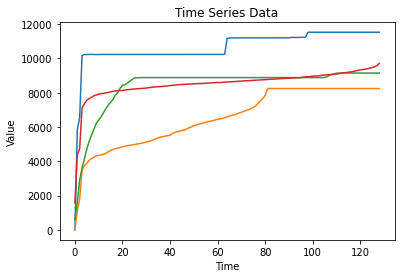

In [ ]:
# Visualize the series
plt.plot(Eventos)
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### Transformaciones

In [ ]:
scaler_MinMax = MinMaxScaler(feature_range=(-1, 1))
# scaled_train_data = scaler_MinMax.fit_transform(train_data)
# scaled_test_data = scaler_MinMax.fit_transform(test_data)
scaled_Eventos = scaler_MinMax.fit_transform(Eventos)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler_Standard = StandardScaler()

# # Fit the scaler to the training data and transform it
# scaled_train_data = scaler_Standard.fit_transform(scaled_train_data)

# # Use the same scaler to transform the test data
# scaled_test_data = scaler_Standard.transform(scaled_test_data)


scaled_Eventos = scaler_Standard.fit_transform(scaled_Eventos)


In [ ]:
train_size = int(len(scaled_Eventos) * 0.75)
train_data = scaled_Eventos[:train_size]
test_data = scaled_Eventos[train_size:]

### Adaptación de los datos para el input de las capas del LSTM

La estructura debe ser X un arreglo de 3 dimensiones (A x B x C):
 - A := # de secuencias
 - B := longitud de cada secuencia
 - C := # de variables

In [ ]:
def create_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps), :]  # Extraer la secuencia con todas las características
        X.append(v)
        y.append(data[i + time_steps, 0])  # Asumiendo que queremos predecir la primera característica
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], data.shape[1])  # Reestructuración a [muestras, pasos de tiempo, características]
    y = np.array(y).reshape(-1, 1)
    return X, y

len_seq = 6 # FUNCIONO MUY BIEN CON 3
# Aplicar la función a los datos de entrenamiento y prueba
X_train, y_train = create_dataset(train_data, len_seq)
X_test, y_test = create_dataset(test_data, len_seq)

print("X_train tiene tamaño: " + str(X_train.shape))
print("y_train tiene tamaño: " + str(y_train.shape))
print("X_test tiene tamaño: " + str(X_test.shape))
print("y_test tiene tamaño: " + str(y_test.shape))

X_train tiene tamaño: (90, 6, 4)
y_train tiene tamaño: (90, 1)
X_test tiene tamaño: (27, 6, 4)
y_test tiene tamaño: (27, 1)


In [ ]:
X_train

Out[124]: array([[[-4.0936794 , -4.56994436, -2.65947492, -5.53154745],
        [-3.72809688, -3.06193492, -2.51665293, -4.8391912 ],
        [-2.95823508, -2.84394544, -2.11355665, -3.92406455],
        ...,
        [-2.65120686, -2.15653202, -1.87207474, -2.63694669],
        [-2.59621673, -2.10815628, -1.81804668, -2.31587444],
        [-1.72299386, -2.07769747, -1.77247519, -2.06481573]],

       [[-3.72809688, -3.06193492, -2.51665293, -4.8391912 ],
        [-2.95823508, -2.84394544, -2.11355665, -3.92406455],
        [-2.75558627, -2.31002051, -1.99704398, -3.41628948],
        ...,
        [-2.59621673, -2.10815628, -1.81804668, -2.31587444],
        [-1.72299386, -2.07769747, -1.77247519, -2.06481573],
        [-1.5290009 , -2.01498817, -1.73911874, -1.8201219 ]],

       [[-2.95823508, -2.84394544, -2.11355665, -3.92406455],
        [-2.75558627, -2.31002051, -1.99704398, -3.41628948],
        [-2.69601363, -2.22103302, -1.91952546, -3.04429828],
        ...,
        [-1.72299

In [ ]:
X_test

Out[123]: array([[[0.8533955 , 0.79856925, 0.92657854, 0.43516318],
        [0.87223471, 0.79856925, 0.92657854, 0.44789292],
        [0.89260143, 0.79856925, 0.92704835, 0.48678934],
        [0.90278478, 0.79856925, 0.92704835, 0.49103258],
        [0.91245897, 0.79856925, 0.92751816, 0.49173979],
        [0.91500481, 0.79856925, 0.92751816, 0.49527583],
        [0.91602315, 0.79856925, 0.92751816, 0.49669024],
        [0.9374082 , 0.80454156, 0.92751816, 0.49669024]],

       [[0.87223471, 0.79856925, 0.92657854, 0.44789292],
        [0.89260143, 0.79856925, 0.92704835, 0.48678934],
        [0.90278478, 0.79856925, 0.92704835, 0.49103258],
        [0.91245897, 0.79856925, 0.92751816, 0.49173979],
        [0.91500481, 0.79856925, 0.92751816, 0.49527583],
        [0.91602315, 0.79856925, 0.92751816, 0.49669024],
        [0.9374082 , 0.80454156, 0.92751816, 0.49669024],
        [0.95675658, 0.80454156, 0.92751816, 0.49173979]],

       [[0.89260143, 0.79856925, 0.92704835, 0.48678934],


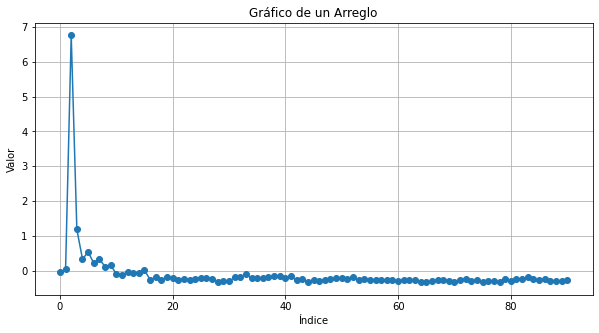

In [ ]:
# Crear un gráfico
plt.figure(figsize=(10, 5))  # Configurar el tamaño del gráfico (opcional)
plt.plot(y_train, marker='o')  # Dibujar los datos, 'marker' para marcar cada punto
plt.title('Gráfico de un Arreglo')  # Título del gráfico
plt.xlabel('Índice')  # Etiqueta del eje x
plt.ylabel('Valor')  # Etiqueta del eje y
plt.grid(True)  # Añadir una cuadrícula
plt.show()  # Mostrar el gráfico

### Red

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping

# Configurar el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    min_delta=0.000001,     # Cambio mínimo en la pérdida de validación para calificar como una mejora
    patience=60,         # Número de épocas sin mejora tras las cuales se detiene el entrenamiento
    verbose=1,           # Imprime información sobre el detenimiento
    mode='auto',         # 'auto', 'min', 'max' - en 'auto', decide automáticamente la dirección del monitoreo
    restore_best_weights=True  # Opcional: restaura los pesos del modelo desde la época con la mejor pérdida observada
)


model = Sequential([
    # Primera capa LSTM con más neuronas y retornando secuencias para la siguiente capa LSTM
    LSTM(200, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.15),
    # BatchNormalization(),


# Usando ReLU como función de activación con recorte de gradientes
    LSTM(80, activation='tanh', recurrent_activation='sigmoid', return_sequences = True),

    Dropout(0.20),
    # BatchNormalization(),

    LSTM(40),

    # Capa densa adicional para mayor procesamiento
    # Dense(50, activation='relu'),
    # BatchNormalization(),
    Dropout(0.15),

    # Capa de salida
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')



# from tensorflow.keras.optimizers import Adam

# optimizer = Adam(0.0007)  # Ajusta la tasa de aprendizaje según sea necesario
# model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=1, callbacks=[early_stopping])

/local_disk0/.ephemeral_nfs/envs/pythonEnv-024ffbf4-e67e-4063-a720-5ad4c438354f/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - loss: 0.1390 - val_loss: 0.3302
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0709 - val_loss: 0.1055
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0494 - val_loss: 0.0084
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0381 - val_loss: 9.9282e-05
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0328 - val_loss: 0.0015
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0342 - val_loss: 0.0074
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0316 - val_loss: 0.0061
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0287 - val_loss: 0.0036
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0283 - val_loss: 0.0104
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0253 - val_loss: 0.0178
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0260 - val_loss: 0.0133
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0221 - v

### Predicciones

In [ ]:
# # Supongamos que `scaled_data` es tu serie de tiempo ya escalada
last_sequence = X_train[-1:]  # Toma los últimos 10 días
last_sequence = last_sequence.reshape((1, len_seq, 4)) 

future_predictions = []

for i in range(26):  # Asumimos que quieres predecir los próximos 20 pasos
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])  # Guarda la predicción hecha para la variable de interés
    
    # Desplaza la secuencia hacia atrás para hacer espacio para el nuevo valor
    last_sequence = np.roll(last_sequence, -1, axis=1)
    
    # Actualiza la variable predicha con la nueva predicción
    last_sequence[0, -1, 0] = next_pred[0, 0]  # Asume que la variable predicha está en la columna 0

    # Actualizar las otras variables con los valores reales del siguiente paso en 'future_data'
    # Asegúrate de que 'future_data' tiene las dimensiones y el orden correcto
    last_sequence[0, -1, 1:] = X_test[i, 0,1:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
# # Supongamos que `scaled_data` es tu serie de tiempo ya escalada
last_sequence = X_train[-1:]  # Toma los últimos 10 días
last_sequence = last_sequence.reshape((1, len_seq, 1))  # Reshape para que coincida con la entrada del modelo


# Asumiendo que 'model' es tu modelo LSTM ya entrenado
future_predictions = []

for _ in range(20):  # Predecir los próximos 10 días
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred[0, 0])  # Guarda la predicción
    
    # Actualiza la secuencia con la predicción
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_pred  # Añade la predicción al final de la secuencia

# reshape de las predicciones
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions.shape







#----------------------------------------------------- PROBAR UN ENFOQUE DIFERENTE A VER SI ES ESTO LO Q FALLA
# X = X_test[0, :] # for the 0th sequence 
# len_forecast = 30
# forecasts = []
# for i in range(len_forecast):
#   y_hat = forecast_lstm(model, 1, X)
#   forecasts.append(y_hat)
#   X = y_hat # use the current prediction for the next round of predictions



# X = X_test[0:1]  # Ensure X is 3D: [1, time steps, features]
# len_forecast = 30
# forecasts = []

# for i in range(len_forecast):
#     y_hat = model.predict(X)  # Assuming model.predict handles the reshaping if necessary
#     forecasts.append(y_hat[0, -1, 0])  # Adjust indexing based on your model output shape
    
#     # Prepare X for the next prediction
#     X = np.roll(X, -1, axis=1)  # Shift data one time-step left
#     X[0, -1, 0] = y_hat[0, -1, 0]  # Insert the new prediction at the end of the array

# # Convert forecasts to an array for further analysis or plotting
# forecasts = np.array(forecasts)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<command-2623164590567276>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = next_day_pred  # Añade la predicción al final de la secuencia


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Out[47]: (20, 1)

### Visualizaciones

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Out[33]: <matplotlib.legend.Legend at 0x7f3f741df1f0>

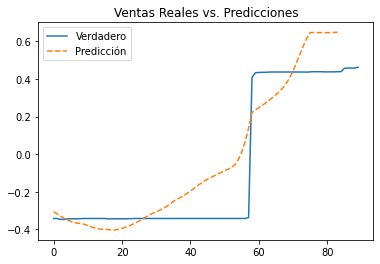

In [ ]:
predictions_Train = model.predict(X_train)
predictions_Train = predictions_Train[len_seq:,:]
# Visualización de las predicciones
import matplotlib.pyplot as plt

plt.plot(y_train, label='Verdadero')
plt.plot(predictions_Train, label='Predicción', linestyle='--')
plt.title('Ventas Reales vs. Predicciones')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


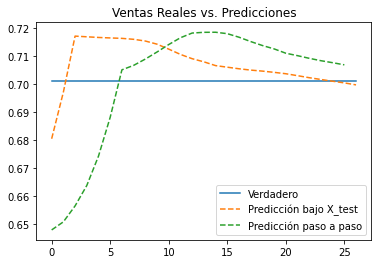

In [ ]:
predictions = model.predict(X_test)
# predictions = predictions[len_seq:,:] # NOTA: Esto se necesitaba cuando era una sola variable

# Visualización de las predicciones
import matplotlib.pyplot as plt

plt.plot(y_test, label='Verdadero')
plt.plot(predictions, label='Predicción bajo X_test', linestyle='--')
plt.plot(future_predictions, label='Predicción paso a paso', linestyle='--')
plt.title('Ventas Reales vs. Predicciones')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


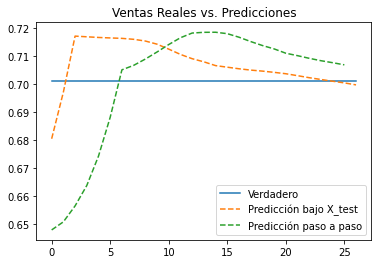

In [ ]:
predictions = model.predict(X_test)
# predictions = predictions[len_seq:,:] # NOTA: Esto se necesitaba cuando era una sola variable

# Visualización de las predicciones
import matplotlib.pyplot as plt

plt.plot(y_test, label='Verdadero')
plt.plot(predictions, label='Predicción bajo X_test', linestyle='--')
plt.plot(future_predictions, label='Predicción paso a paso', linestyle='--')
plt.title('Ventas Reales vs. Predicciones')
plt.legend()
plt.show()

### Destransformaciones

In [ ]:
future_predictions_array = np.array(future_predictions)

# Si necesitas que sea un array bidimensional (lo cual es común en scikit-learn), reforma el array
future_predictions_array = future_predictions_array.reshape(-1, 1)  # Reforma como un vector columna

# Ahora puedes proceder a usar el scaler para desescalar
# Asegúrate de que tu 'scaler_y' espera la misma forma que proporcionas
# predictions_original_scale = scaler_Standard.inverse_transform(future_predictions_array)

# Si el scaler fue entrenado en múltiples características y necesitas usar el dummy data approach:
dummy_data = np.zeros((future_predictions_array.shape[0], 4))  # Ajusta '4' al número correcto de características
dummy_data[:, 0] = future_predictions_array.squeeze()  # Suponiendo que la característica de interés es la primera
pred_desc = scaler_Standard.inverse_transform(dummy_data)
#----------
dummy_data2 = np.zeros((y_test.shape[0], 4))  # Ajusta '4' al número correcto de características
dummy_data2[:, 0] = y_test.squeeze()

y_test_desc = scaler_Standard.inverse_transform(dummy_data2)


#----------
dummy_data3 = np.zeros((y_train.shape[0], 4))  # Ajusta '4' al número correcto de características
dummy_data3[:, 0] = y_train.squeeze()

y_train_desc = scaler_Standard.inverse_transform(dummy_data3)


#------------------------------------------------------------------------------------------------------------------------
# y_test_desc.shape
y_test_detransformed = scaler_MinMax.inverse_transform(y_test_desc)[:, 0]
y_train_detransformed = scaler_MinMax.inverse_transform(y_train_desc)[:, 0]
future_predictions_detransformed = scaler_MinMax.inverse_transform(pred_desc)[:, 0]










In [ ]:
# Revertir la transformación en los datos de entrenamiento
predictions_detransformed = scaler_Standard.inverse_transform(predictions)
# y_test_detransformed = scaler_Standard.inverse_transform(y_test)
# future_predictions_detransformed = scaler_Standard.inverse_transform(future_predictions)


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-237198855947707>:2
      1 # Revertir la transformación en los datos de entrenamiento
----> 2 predictions_detransformed = scaler_Standard.inverse_transform(predictions)

File /databricks/python/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:1035, in StandardScaler.inverse_transform(self, X, copy)
   1033 else:
   1034     if self.with_std:
-> 1035         X *= self.scale_
   1036     if self.with_mean:
   1037         X += self.mean_

ValueError: non-broadcastable output operand with shape (27,1) doesn't match the broadcast shape (27,4)

In [ ]:
# Revertir la transformación en los datos de entrenamiento
predictions_detransformed = scaler_MinMax.inverse_transform(predictions_detransformed)
# y_test_detransformed = scaler_MinMax.inverse_transform(y_test_detransformed)
# future_predictions_detransformed = scaler_MinMax.inverse_transform(future_predictions_detransformed)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2032646847868224>:2
      1 # Revertir la transformación en los datos de entrenamiento
----> 2 predictions_detransformed = scaler_MinMax.inverse_transform(predictions_detransformed)

NameError: name 'predictions_detransformed' is not defined

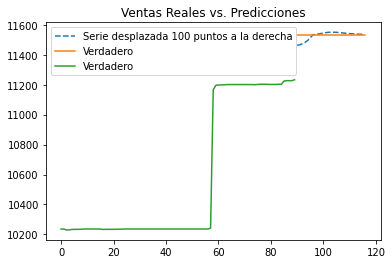

In [ ]:

# x_original = np.arange(len(future_predictions_detransformed))

# Crear un array x desplazado
x_desplazado = np.arange(90, 90 + len(future_predictions_detransformed))

# Graficar ambos
# plt.figure(figsize=(10, 5))
# plt.plot(x_original, y, label='Serie original')
plt.plot(x_desplazado, future_predictions_detransformed, label='Serie desplazada 100 puntos a la derecha', linestyle='--')

x_desplazado = np.arange(90, 90 + len(y_test_detransformed))
plt.plot(x_desplazado, y_test_detransformed, label='Verdadero')
plt.plot(y_train_detransformed, label='Verdadero')
# plt.plot(predictions_detransformed, label='Predicción X_test', linestyle='--')
# plt.plot(future_predictions_detransformed, label='Predicción paso a paso', linestyle='--')
plt.title('Ventas Reales vs. Predicciones')
plt.legend()
plt.show()

In [ ]:
future_predictions_detransformed

Out[37]: array([8257.79289112, 8262.55812466, 8270.99865242, 8283.93126281,
       8301.50896095, 8323.55603203, 8349.49027005, 8376.95658901,
       8388.00112151, 8400.28365053, 8411.65804478, 8423.64242953,
       8435.61057492, 8446.57035833, 8455.87753439, 8462.47679925,
       8469.14152897, 8475.41118582, 8481.13428713])

### Métricas

In [ ]:
c1 = c.iloc[30:]
r2_score(c1, d)
evaluation_results = pd.DataFrame({'r2_score': r2_score(c1, d)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(c1, d)
evaluation_results['mean_squared_error'] = mean_squared_error(c1, d)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(d - c1)/np.abs(c1))*100
evaluation_results

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}')